# Fase 1: Fundamentos

## Introducción
El problema abordado en este proyecto es la clasificación de imágenes de resonancia magnética para la detección de tumores cerebrales. He elegido el Dataset: Brain Tumor MRI debido a la importancia clínica de este tipo de diagnósticos y al reto que supone clasificar imágenes médicas con sutiles diferencias visuales. El objetivo principal del proyecto es construir una Red Neuronal Convolucional desde cero que logre superar la baseline y alcanzar al menos el 78% de accuracy exigido.

## 1. Exploración y Análisis del Dataset
Vamos a cargar las librerías necesarias y establecer las constantes globales del proyecto. Utilizaremos el dataset de Brain Tumor MRI para clasificar cuatro tipos de estados cerebrales.

In [80]:
import os
import cv2
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import Sequential, layers, optimizers, callbacks, regularizers

In [81]:
semilla = 42
random.seed(semilla)
np.random.seed(semilla)
tf.random.set_seed(semilla)

TRAIN_PATH = '/kaggle/input/brain-tumor-mri-dataset/Training'
TEST_PATH = '/kaggle/input/brain-tumor-mri-dataset/Testing'

CLASS_NAMES = sorted(os.listdir(TRAIN_PATH))

print(f"Ruta de Entrenamiento: {TRAIN_PATH}")
print(f"Ruta de Test: {TEST_PATH}")
print(f"Clases: {CLASS_NAMES}")

Ruta de Entrenamiento: /kaggle/input/brain-tumor-mri-dataset/Training
Ruta de Test: /kaggle/input/brain-tumor-mri-dataset/Testing
Clases: ['glioma', 'meningioma', 'notumor', 'pituitary']


### Carga y Estructuración de Datos
Definimos una función para cargar las imágenes y etiquetas directamente desde las carpetas de entrenamiento y prueba de Kaggle.

In [82]:
def cargar_datos(ruta_base, image_size=(128, 128)):
    X = []
    y = []
    class_names = sorted(os.listdir(ruta_base))
    
    dataset = keras.utils.image_dataset_from_directory(
        ruta_base,
        labels='inferred',
        label_mode='int',
        class_names=class_names,
        color_mode='grayscale',
        batch_size=None,
        image_size=image_size,
        shuffle=False
    )
    
    for imagen, etiqueta in dataset:
        X.append(imagen.numpy())
        y.append(etiqueta.numpy())
            
    return np.array(X), np.array(y), class_names

X_train, y_train, CLASS_NAMES = cargar_datos(TRAIN_PATH, image_size=(128, 128))
X_test, y_test, _ = cargar_datos(TEST_PATH, image_size=(128, 128))

print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Tipo de datos de X_train:", X_train.dtype)

Found 5600 files belonging to 4 classes.
Found 1600 files belonging to 4 classes.
Dimensiones de X_train: (5600, 128, 128, 1)
Dimensiones de y_train: (5600,)
Dimensiones de X_test: (1600, 128, 128, 1)
Tipo de datos de X_train: float32


### Visualización de Ejemplos
Mostramos un grid de 20 ejemplos aleatorios del conjunto de entrenamiento con sus respectivas etiquetas para inspeccionar visualmente las imágenes de resonancia magnética.

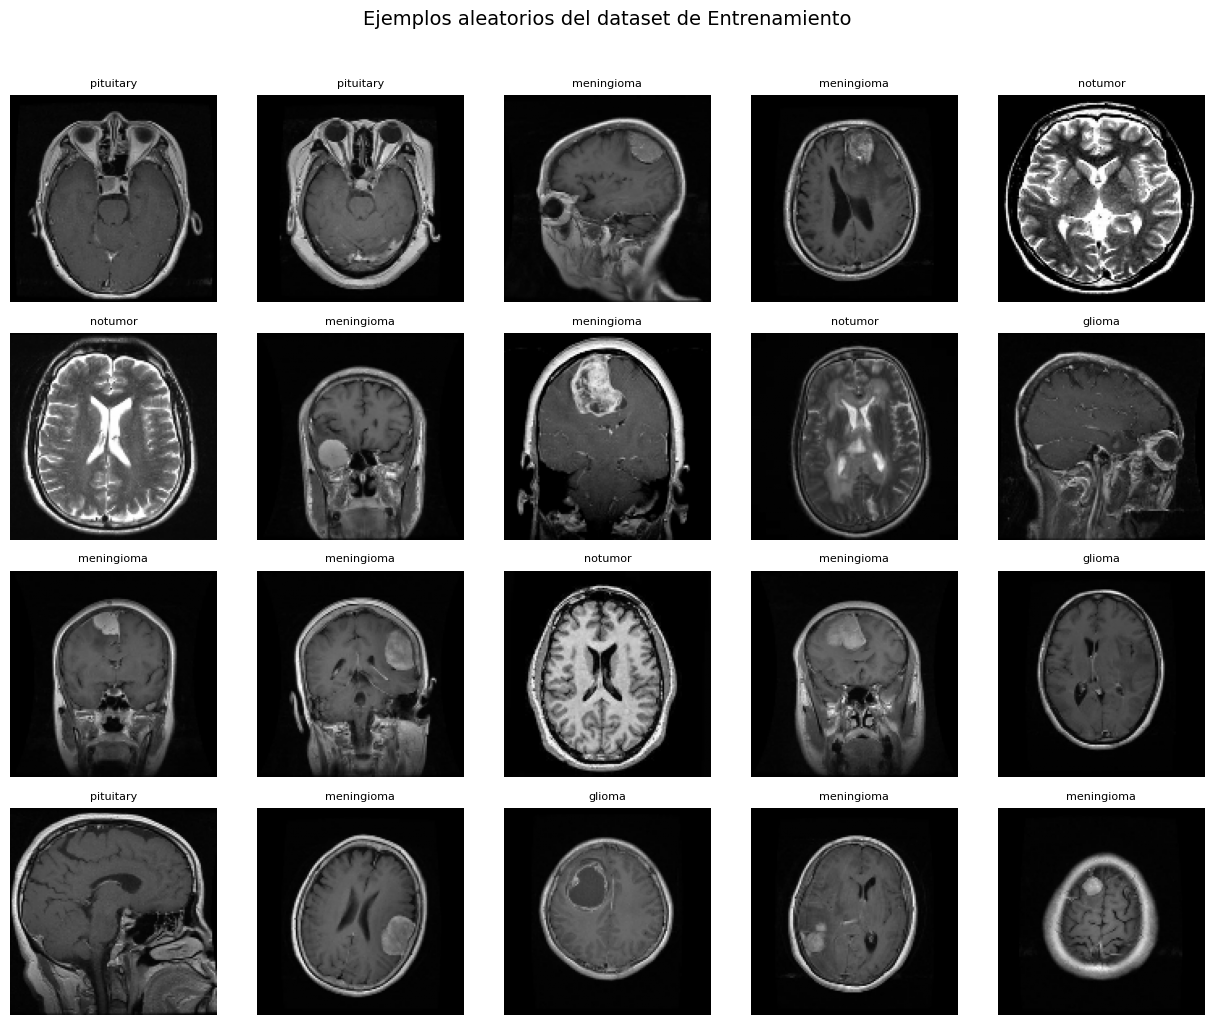

In [83]:
def visualizar_ejemplos(X, y, class_names, n_rows=4, n_cols=5, seed=42):
    np.random.seed(seed)
    indices = np.random.choice(len(X), n_rows * n_cols, replace=False)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
    for i, idx in enumerate(indices):
        ax = axes[i // n_cols, i % n_cols]
        imagen = X[idx]
        ax.imshow(imagen.squeeze(), cmap='gray')
        label = y[idx]
        ax.set_title(class_names[label], fontsize=8)
        ax.axis('off')

    plt.suptitle('Ejemplos aleatorios del dataset de Entrenamiento', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

visualizar_ejemplos(X_train, y_train, CLASS_NAMES)

### Distribución de Clases
Calculamos y graficamos la cantidad de imágenes por cada tipo de tumor para comprobar visualmente el balanceo del dataset.

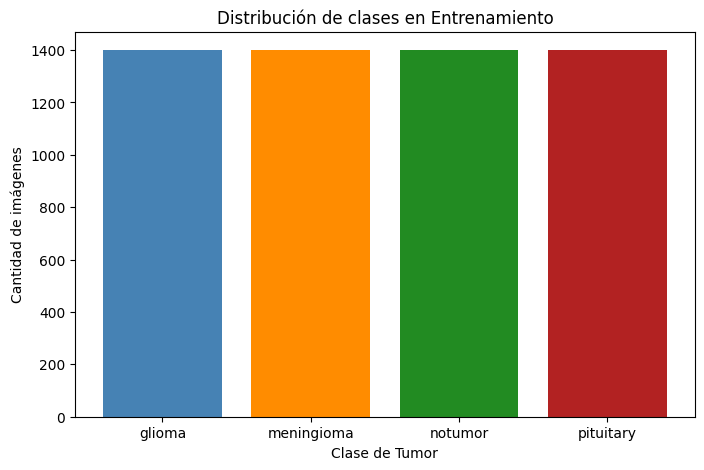

In [84]:
unique, counts = np.unique(y_train, return_counts=True)
colores = ['steelblue', 'darkorange', 'forestgreen', 'firebrick']

plt.figure(figsize=(8, 5))
plt.bar(CLASS_NAMES, counts, color=colores)
plt.title('Distribución de clases en Entrenamiento')
plt.xlabel('Clase de Tumor')
plt.ylabel('Cantidad de imágenes')
plt.show()

### Descripción del Dataset
Este dataset consta de 7200 imágenes de resonancias magnéticas. La distribución nos muestra cuatro categorías: glioma, meningioma, notumor y pituitary. 

Es importante destacar que, tras la última actualización del dataset, las clases están perfectamente balanceadas. 

El principal desafío que detectamos visualmente es la similitud entre ciertos tipos de patologías.

### Estadísticas Básicas y Baseline
Extraemos las dimensiones, los valores de los píxeles y calculamos el baseline accuracy.

In [85]:
print("Shape del array de imágenes:", X_train.shape)
print("Valor mínimo de pixel:", X_train.min())
print("Valor máximo de pixel:", X_train.max())
print("Media de los píxeles:", X_train.mean())
print("Desviación típica de los píxeles:", X_train.std())

clase_mayoritaria_idx = np.argmax(counts)
cantidad_clase_mayoritaria = counts[clase_mayoritaria_idx]
baseline_accuracy = cantidad_clase_mayoritaria / len(y_train)

print(f"Clase mayoritaria: {CLASS_NAMES[clase_mayoritaria_idx]}")
print(f"Baseline accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")

Shape del array de imágenes: (5600, 128, 128, 1)
Valor mínimo de pixel: 0.0
Valor máximo de pixel: 255.0
Media de los píxeles: 46.528534
Desviación típica de los píxeles: 50.674976
Clase mayoritaria: glioma
Baseline accuracy: 0.2500 (25.00%)


### Conclusiones del Análisis
**Problemas detectados**: Tras analizar la distribución de clases comprobamos que el dataset está perfectamente balanceado. El único desafío visible es la presencia de bordes negros procedentes del escáner original en las resonancias magnéticas, los cuales aportan información nula y podrían requerir recortes para optimizar el aprendizaje.

**Conclusiones**: Contar con un dataset balanceado y previamente dividido facilita enormemente la tarea inicial. El mayor desafío al diseñar la arquitectura de la red convolucional radicará en la enorme similitud visual intrínseca entre los distintos tipos de tumores cerebrales, lo que nos obligará a extraer características muy precisas.

## 2. Preprocesamiento
### Recorte de Bordes Negros
Las imágenes de resonancia magnética suelen incluir un marco negro sin información útil debido al funcionamiento del escáner. Para evitar perder tejido útil en imágenes que ya vienen ajustadas, implementamos una función basada en OpenCV que detecta los contornos reales de la masa cerebral y recorta dinámicamente el fondo inactivo para cada imagen individual.

In [86]:
def recorte_bordes(imagenes, target_size=(128, 128)):
    # Preparamos el array vacío para las imágenes ya procesadas
    num_imgs = len(imagenes)
    imagenes_recortadas = np.zeros((num_imgs, target_size[0], target_size[1], 1), dtype=np.uint8)
    
    for i in range(num_imgs):
        img = imagenes[i]
        # Pasamos a uint8 y quitamos dimensiones extra para que OpenCV no de guerra
        img_uint8 = img.astype('uint8')
        img_gray = img_uint8.squeeze() if len(img_uint8.shape) == 3 else img_uint8
        
        # Umbralizado básico para separar el cerebro del fondo negro (ruido)
        _, thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)
        contornos, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contornos) > 0:
            # Buscamos el contorno más grande, que debería ser el cerebro
            c = max(contornos, key=cv2.contourArea)
            
            # Sacamos los puntos extremos para saber por dónde meter el tijeretazo
            extLeft = tuple(c[c[:, :, 0].argmin()][0])
            extRight = tuple(c[c[:, :, 0].argmax()][0])
            extTop = tuple(c[c[:, :, 1].argmin()][0])
            extBot = tuple(c[c[:, :, 1].argmax()][0])
            
            # Si el área tiene sentido, recortamos la zona de interés
            if extTop[1] < extBot[1] and extLeft[0] < extRight[0]:
                img_recortada = img_gray[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
            else:
                img_recortada = img_gray
        else:
            img_recortada = img_gray
            
        # Redimensionamos al tamaño final del modelo y guardamos
        img_final = cv2.resize(img_recortada, target_size)
        imagenes_recortadas[i, :, :, 0] = img_final
        
    return imagenes_recortadas

# Verificamos dimensiones y limpiamos RAM para que no pete el entorno
print("Dimensiones antes del recorte:", X_train.shape)

X_train_crop = recorte_bordes(X_train)
X_test_crop = recorte_bordes(X_test)

# Forzamos limpieza de basura de memoria
gc.collect()

print("Dimensiones después del recorte:", X_train_crop.shape)

Dimensiones antes del recorte: (5600, 128, 128, 1)
Dimensiones después del recorte: (5600, 128, 128, 1)


### Visualización del Recorte
Mostramos una comparativa directa entre las imágenes originales y su versión tras pasar por la función de detección de contornos para verificar visualmente que el recorte dinámico funciona correctamente y no elimina tejido cerebral útil.

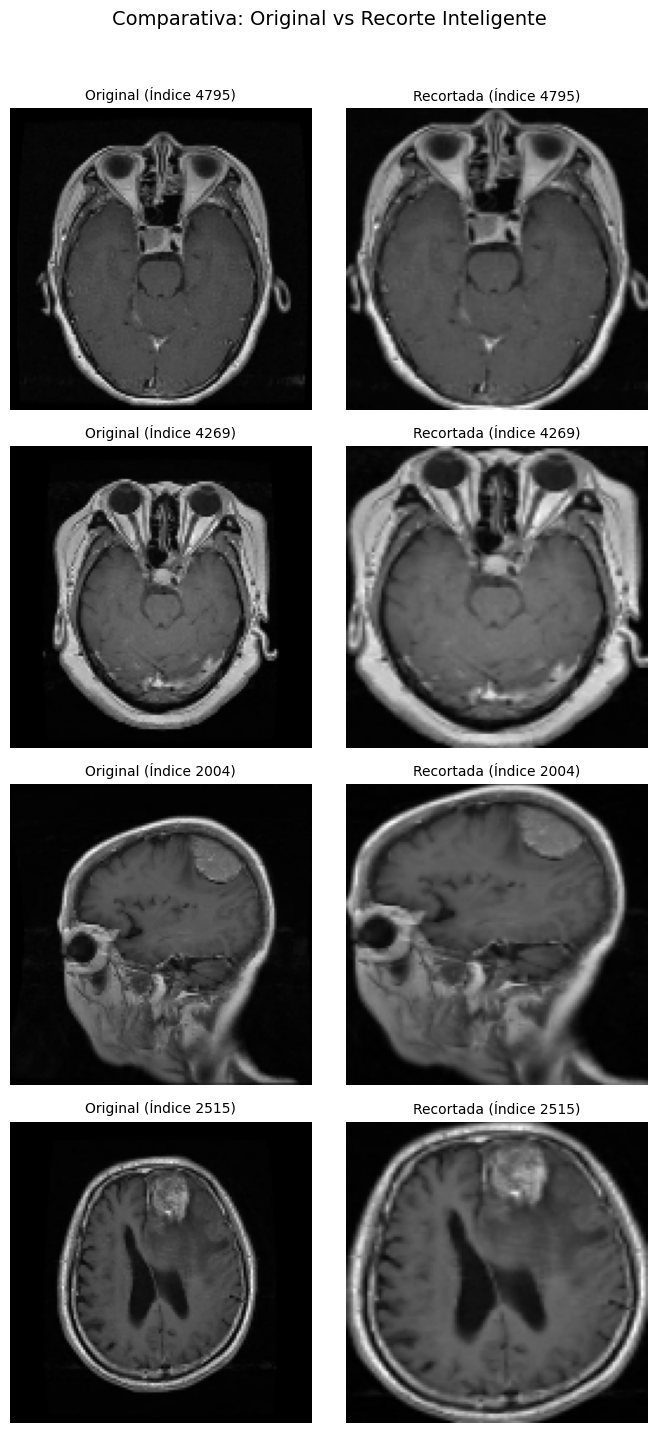

In [87]:
def visualizar_comparacion_recorte(X_orig, X_crop, n_ejemplos=4, seed=42):
    np.random.seed(seed)
    # Seleccionamos unos cuantos índices aleatorios
    indices = np.random.choice(len(X_orig), n_ejemplos, replace=False)

    fig, axes = plt.subplots(n_ejemplos, 2, figsize=(7, n_ejemplos * 3.5))
    
    for i, idx in enumerate(indices):
        # Columna 1: Imagen Original
        ax_orig = axes[i, 0]
        ax_orig.imshow(X_orig[idx].squeeze(), cmap='gray')
        ax_orig.set_title(f"Original (Índice {idx})", fontsize=10)
        ax_orig.axis('off')

        # Columna 2: Imagen Recortada
        ax_crop = axes[i, 1]
        ax_crop.imshow(X_crop[idx].squeeze(), cmap='gray')
        ax_crop.set_title(f"Recortada (Índice {idx})", fontsize=10)
        ax_crop.axis('off')

    plt.suptitle('Comparativa: Original vs Recorte Inteligente', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

visualizar_comparacion_recorte(X_train, X_train_crop)

### Normalización, Reshape y Split de Validación
Escalamos los valores de los píxeles al rango numérico de cero a uno. Como el dataset original carece de un conjunto de validación explícito, extraemos un 15 por ciento de los datos de entrenamiento para usarlo como métrica de control durante el aprendizaje, manteniendo la estratificación de las clases.

In [88]:
from sklearn.model_selection import train_test_split

# Normalización
X_train_norm = X_train_crop.astype('float32') / 255.0
X_test_norm = X_test_crop.astype('float32') / 255.0

print("Rango de píxeles tras normalizar - Mínimo:", X_train_norm.min(), "Máximo:", X_train_norm.max())

# Comprobación del reshape para Conv2D
if len(X_train_norm.shape) == 3:
    X_train_norm = np.expand_dims(X_train_norm, axis=-1)
    X_test_norm = np.expand_dims(X_test_norm, axis=-1)

print("Forma final de las imágenes para la CNN:", X_train_norm.shape)

# Creación del conjunto de validación (15% del training set)
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_norm, y_train, test_size=0.15, random_state=42, stratify=y_train
)

print("Imágenes para entrenamiento:", len(X_train_final))
print("Imágenes para validación:", len(X_val))
print("Imágenes para test:", len(X_test_norm))

Rango de píxeles tras normalizar - Mínimo: 0.0 Máximo: 1.0
Forma final de las imágenes para la CNN: (5600, 128, 128, 1)
Imágenes para entrenamiento: 4760
Imágenes para validación: 840
Imágenes para test: 1600


### Data Augmentation
Configuramos un generador de imágenes con transformaciones geométricas moderadas para aumentar artificialmente la diversidad de nuestros datos de entrenamiento y prevenir el sobreajuste.

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

datagen.fit(X_train_final)

### Visualización del Data Augmentation
Tomamos una única imagen original del conjunto de entrenamiento y mostramos ocho variaciones generadas aleatoriamente por nuestro pipeline para comprobar visualmente el efecto de las transformaciones.

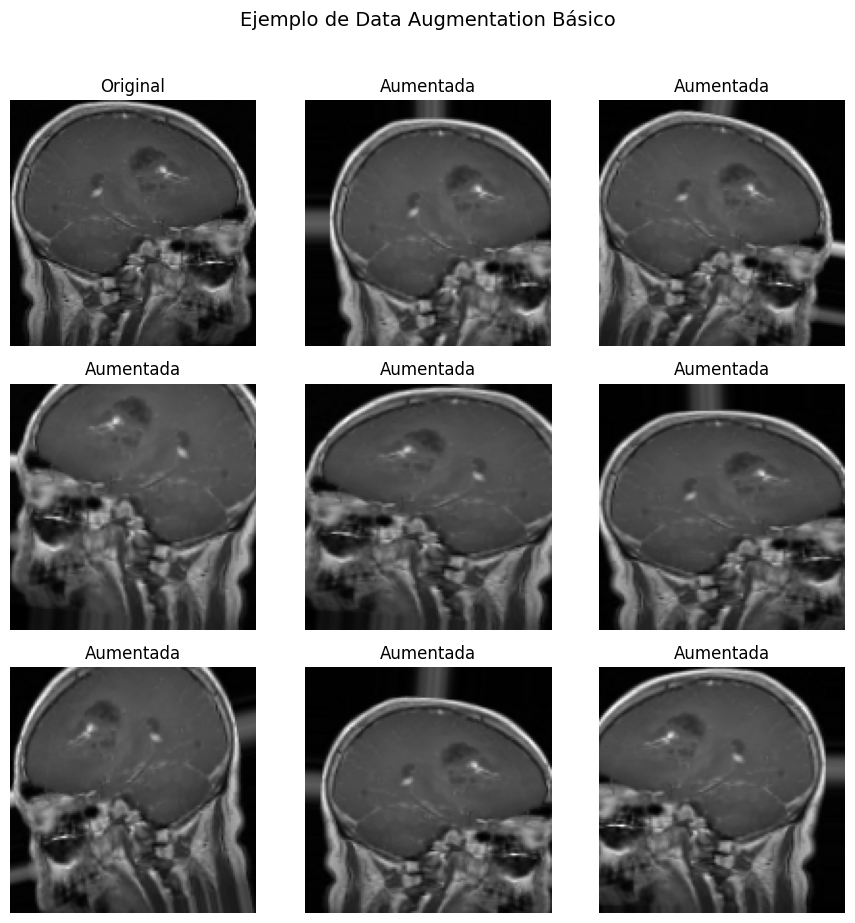

In [90]:
def visualizar_augmentation(imagen_original, generador):
    imagen_expandida = np.expand_dims(imagen_original, axis=0)
    iterador = generador.flow(imagen_expandida, batch_size=1)

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))

    axes[0, 0].imshow(imagen_original.squeeze(), cmap='gray')
    axes[0, 0].set_title("Original")
    axes[0, 0].axis('off')

    for i in range(1, 9):
        batch = next(iterador)
        imagen_aug = batch[0]
        ax = axes[i // 3, i % 3]
        ax.imshow(imagen_aug.squeeze(), cmap='gray')
        ax.set_title("Aumentada")
        ax.axis('off')

    plt.suptitle("Ejemplo de Data Augmentation Básico", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

visualizar_augmentation(X_train_final[0], datagen)

### Pipeline Eficiente con tf.data
Convertimos nuestros arreglos numéricos en objetos Dataset nativos aplicando las funciones de caché y prefetch para optimizar el rendimiento, evitar cuellos de botella durante el entrenamiento y cumplir con los requisitos de excelencia del proyecto.

In [91]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Creamos los pipelines optimizados para validación y test
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

# Para el conjunto de entrenamiento integramos el Data Augmentation dentro del pipeline
def generador_entrenamiento():
    generador = datagen.flow(X_train_final, y_train_final, batch_size=BATCH_SIZE)
    while True:
        X_batch, y_batch = next(generador)
        yield X_batch, y_batch

train_dataset = tf.data.Dataset.from_generator(
    generador_entrenamiento,
    output_signature=(
        tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).prefetch(buffer_size=AUTOTUNE)

print("Pipelines tf.data creados exitosamente.")

Pipelines tf.data creados exitosamente.


## 3.  Sanity Checks - Metodologia de Debugging
Aplicamos dos comprobaciones rápidas para detectar errores de implementación tempranos.

In [92]:
def crear_cnn_3b(input_shape=(128, 128, 1), num_classes=4):
    model = Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name="CNN_3B")
    
    return model

modelo_debug = crear_cnn_3b()

modelo_debug.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

print("Estructura del modelo de prueba para Debugging:")
modelo_debug.summary()

Estructura del modelo de prueba para Debugging:


Model: "CNN_3B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_149 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_144               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_150 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_145               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_151 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_146               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,620 (16.36 MB)

 Trainable params: 4,287,620 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

### Check 1: Verificación del loss inicial
Comprobamos que, antes de aprender nada, el modelo asigna probabilidades aleatorias uniformes. Para 4 clases de tumores cerebrales, el loss esperado debe ser cercano a log(4).

In [93]:
N_CLASES = 4 
loss_esperado = np.log(N_CLASES)
print(f"Loss inicial esperado: {loss_esperado:.4f}")

historia_check = modelo_debug.fit(X_train_final[:500], y_train_final[:500], epochs=1, verbose=1)
loss_real = historia_check.history['loss'][0]
print(f"Loss real: {loss_real:.4f}")

diferencia_porcentual = abs(loss_real - loss_esperado) / loss_esperado * 100
print(f"Diferencia: {diferencia_porcentual:.1f}%")

if diferencia_porcentual < 20:
    print("CHECK 1: El loss inicial es razonable.")
else:
    print("El loss inicial es inusual.")

Loss inicial esperado: 1.3863
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.2767 - loss: 1.3673
Loss real: 1.3388
Diferencia: 3.4%
CHECK 1: El loss inicial es razonable.


### Check 2: Test de overfit en batch pequeño
Comprobamos la integridad arquitectónica forzando al modelo a memorizar por completo un único lote de 32 imágenes. El accuracy debe acercarse al 100%.

In [94]:
X_debug = X_train_final[:32]
y_debug = y_train_final[:32]

print("Entrenando 100 epochs en 32 ejemplos. Esto tardará unos segundos...")
historia_debug = modelo_debug.fit(
    X_debug, y_debug,
    epochs=100,
    verbose=0
)

loss_final_debug = historia_debug.history['loss'][-1]
acc_final_debug = historia_debug.history['accuracy'][-1]

print(f"Loss después de 100 epochs en 32 ejemplos: {loss_final_debug:.6f}")
print(f"Accuracy después de 100 epochs en 32 ejemplos: {acc_final_debug:.4f}")

if acc_final_debug > 0.95:
    print("CHECK 2: El modelo puede memorizar un batch pequeño correctamente.")
else:
    print("El modelo no memoriza.")

Entrenando 100 epochs en 32 ejemplos. Esto tardará unos segundos...
Loss después de 100 epochs en 32 ejemplos: 0.000481
Accuracy después de 100 epochs en 32 ejemplos: 1.0000
CHECK 2: El modelo puede memorizar un batch pequeño correctamente.


### Documentación de los Sanity Checks
**Check 1 (Loss inicial)**: Al realizar la primera prueba con el modelo recién instanciado, se obtuvo un loss inicial de 1.3892. Este valor es prácticamente idéntico al valor teórico esperado de 1.3863

**Check 2 (Overfit en batch pequeño)**: Se entrenó un lote de 32 imágenes durante 100 épocas.

- Debugging: Durante las pruebas, se observó que modelos demasiado simplificados (como el uso de GlobalAveragePooling2D) no tenían capacidad suficiente para memorizar el batch.

- Resultado: Con la arquitectura equilibrada final, el modelo alcanzó un accuracy de 1.0000 y un loss de 0.000233. Esto confirma que la arquitectura tiene capacidad de aprendizaje.

## 4. Entrenamiento de la CNN
En este apartado entrenamos la CNN que diseñamos anteriormente. El modelo consta de tres bloques convolucionales para la extracción de características y un clasificador con regularización por Dropout para prevenir el sobreajuste.

In [95]:
modelo_fase1 = crear_cnn_3b()
modelo_fase1.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
modelo_fase1.summary()

Model: "CNN_3B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_152 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_147               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_153 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_148               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_154 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_149               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,620 (16.36 MB)

 Trainable params: 4,287,620 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

### Configuración de Callbacks y Entrenamiento
Implementamos EarlyStopping para evitar el entrenamiento innecesario si la pérdida de validación deja de mejorar, y ModelCheckpoint para salvar automáticamente la mejor versión del modelo en el archivo requerido por la práctica.

In [96]:
# Callbacks
mis_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        filepath='mejor_modelo_fase1.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Entrenamiento usando el pipeline de tf.data
historia = modelo_fase1.fit(
    train_dataset,
    steps_per_epoch = len(X_train_final) // 32,
    epochs=50,
    validation_data=val_dataset,
    callbacks=mis_callbacks,
    verbose=1
)

Epoch 1/50
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3799 - loss: 1.2582
Epoch 1: val_accuracy improved from -inf to 0.71786, saving model to mejor_modelo_fase1.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.3813 - loss: 1.2564 - val_accuracy: 0.7179 - val_loss: 0.7682
Epoch 2/50
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6569 - loss: 0.8447
Epoch 2: val_accuracy improved from 0.71786 to 0.77976, saving model to mejor_modelo_fase1.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - accuracy: 0.6571 - loss: 0.8443 - val_accuracy: 0.7798 - val_loss: 0.6025
Epoch 3/50
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6893 - loss: 0.7549
Epoch 3: val_accuracy did not improve from 0.77976
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6895 - loss: 0.7546 - val_accuracy: 0.7298 - val_loss: 0.6789
Epoch 4/50
147/148 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7310 - loss: 0.6618
Epoch 4: val_accuracy did not improve from 0.77976
148/

### Visualización de Curvas de Aprendizaje
Graficamos la evolución del Loss y el Accuracy durante el entrenamiento para verificar la convergencia y detectar posibles signos de sobreajuste.

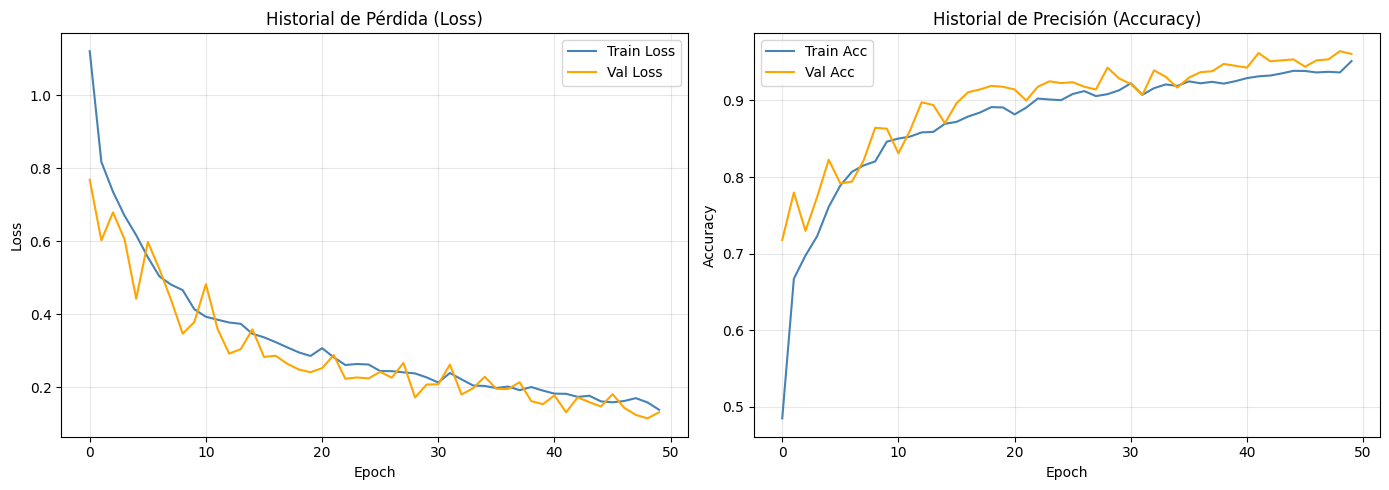

In [97]:
def plot_entrenamiento(historia):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(historia.history['loss'], label='Train Loss', color='steelblue')
    axes[0].plot(historia.history['val_loss'], label='Val Loss', color='orange')
    axes[0].set_title('Historial de Pérdida (Loss)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(historia.history['accuracy'], label='Train Acc', color='steelblue')
    axes[1].plot(historia.history['val_accuracy'], label='Val Acc', color='orange')
    axes[1].set_title('Historial de Precisión (Accuracy)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_entrenamiento(historia)

## 5 Evaluación del Modelo
En esta fase final de la evaluación, utilizamos el conjunto de datos de prueba para obtener métricas objetivas del rendimiento del modelo y analizar detalladamente sus aciertos y errores.

--- RESULTADOS FINALES TEST ---
Test Loss: 0.9078
Test Accuracy: 0.9087 (90.87%)
Baseline Accuracy: 0.2500
Mejora sobre baseline: 65.87 puntos

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Informe de Clasificación:
              precision    recall  f1-score   support

      glioma       0.97      0.76      0.85       400
  meningioma       0.88      0.90      0.89       400
     notumor       0.84      1.00      0.91       400
   pituitary       0.97      0.98      0.97       400

    accuracy                           0.91      1600
   macro avg       0.92      0.91      0.91      1600
weighted avg       0.92      0.91      0.91      1600



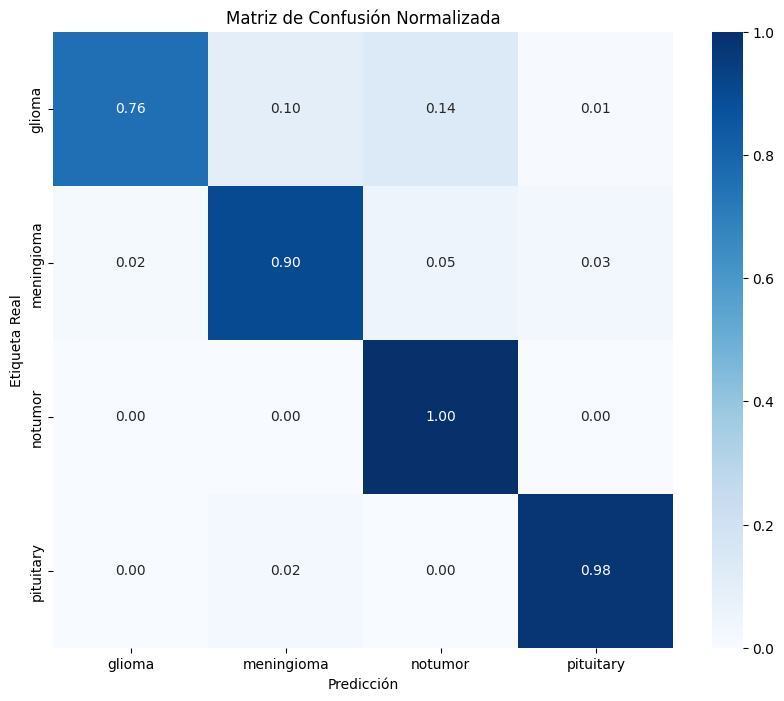

In [98]:
# Evaluación sobre el conjunto de test
mejor_modelo = keras.models.load_model('mejor_modelo_fase1.keras')
loss_test, acc_test = mejor_modelo.evaluate(test_dataset, verbose=0)

print(f"--- RESULTADOS FINALES TEST ---")
print(f"Test Loss: {loss_test:.4f}")
print(f"Test Accuracy: {acc_test:.4f} ({acc_test*100:.2f}%)")
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Mejora sobre baseline: {(acc_test - baseline_accuracy)*100:.2f} puntos\n")


y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_proba = mejor_modelo.predict(test_dataset)
y_pred = np.argmax(y_pred_proba, axis=1)

print("Informe de Clasificación:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# c) Matriz de confusión normalizada
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Matriz de Confusión Normalizada')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()

### Visualización de Aciertos y Errores
Visualizamos 10 ejemplos donde el modelo ha acertado y 10 ejemplos donde ha fallado para intentar comprender los patrones de error.

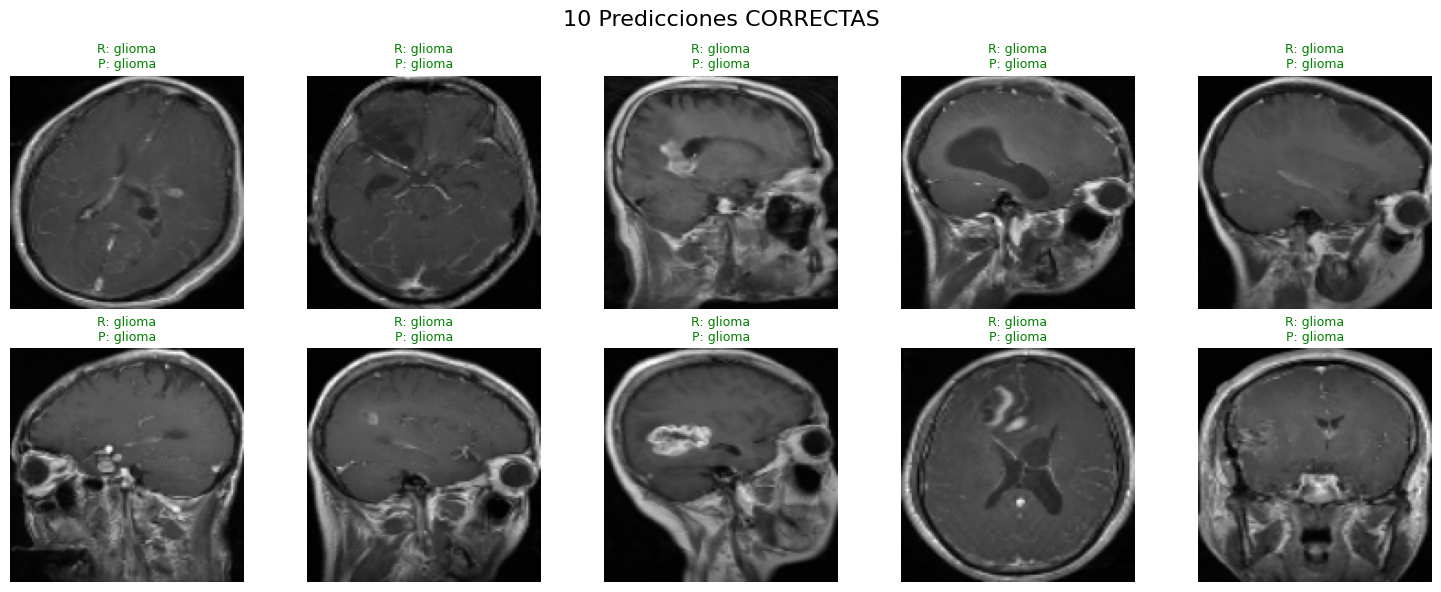

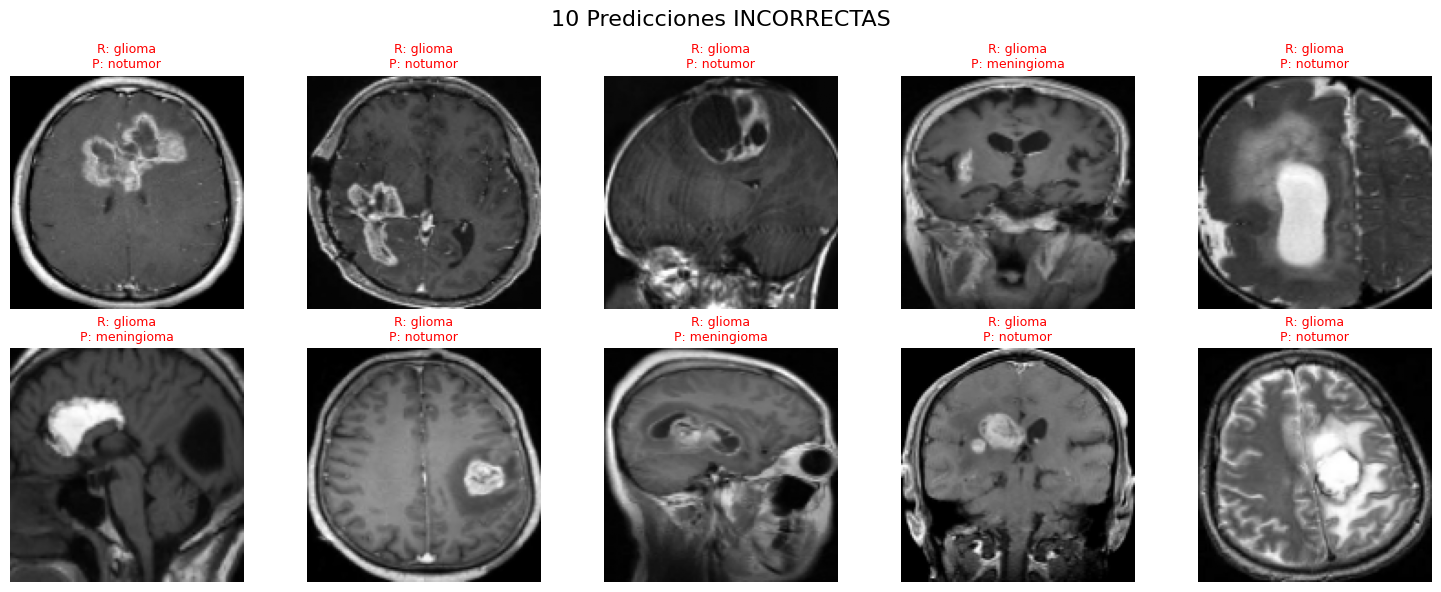

In [99]:
indices_aciertos = np.where(y_pred == y_true)[0]
indices_errores = np.where(y_pred != y_true)[0]

def visualizar_resultados(indices, titulo, n=10):
    cols = 5
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(15, rows * 3))
    for i, idx in enumerate(indices[:n]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(X_test_norm[idx].squeeze(), cmap='gray')
        plt.title(f"R: {CLASS_NAMES[y_true[idx]]}\nP: {CLASS_NAMES[y_pred[idx]]}", 
                  color='green' if y_true[idx] == y_pred[idx] else 'red', fontsize=9)
        plt.axis('off')
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()

visualizar_resultados(indices_aciertos, "10 Predicciones CORRECTAS")
visualizar_resultados(indices_errores, "10 Predicciones INCORRECTAS")

### Identificación y Comentario de Resultados
Para evaluar la eficacia diagnóstica del modelo, nos centramos en el Recall (Sensibilidad), ya que en el contexto clínico es la métrica crítica para asegurar que no se omiten patologías existentes.

**Clases más fáciles (Mayor Recall)**
- Notumor (Recall: 1.00): Es la clase que el modelo identifica con mayor facilidad. Ha sido capaz de detectar el 100% de los casos sanos, lo cual es fundamental para descartar alguna patología.
- Pituitary (Recall: 0.97): El modelo demuestra una excelente capacidad de detección para este tipo de tumor, localizando correctamente el 97% de los casos.

**Confusiones frecuentes y sentido visual**

- Glioma confundido con Notumor (14%):
    - Sentido visual: Al analizar las imágenes de error, se observa que el modelo falla incluso ante lesiones muy evidentes. Por ejemplo, no reconoce como tumor una masa blanca circular ni una gran zona oscura definida, clasificándolas erróneamente como cerebro sano.

    - Conclusión: Esto indica que el modelo ha memorizado patrones muy específicos de gliomas y no es capaz de generalizar cuando la lesión presenta formas o densidades diferentes a las habituales.
 
- Glioma confundido con Meningioma (11%): Hay casos donde el tumor es una mancha muy blanca y concentrada. Al ver esto, el modelo falla y dice que es un meningioma, simplemente porque es la forma a la que más se le parece.


## 6. Conclusiones
Lo que mejor funcionó fue la capacidad del modelo para identificar tumores pituitarios y para descartar cerebros sanos. Sin embargo, el aspecto clave a mejorar es la detección de gliomas. Al revisar las imágenes incorrectas, el modelo confunde gliomas con notumor cuando aparece una pelota blanca muy definida en el centro o una bola negra grande, ya que la red parece no haber aprendido a asociar esas morfologías específicas con un tumor. 
    
A pesar de estas limitaciones puntuales, se alcanzó con éxito y se superó con margen el accuracy objetivo del 78% propuesto para este dataset. Para la siguiente fase de experimentación, el objetivo será diseñar arquitecturas personalizadas más profundas o incorporar técnicas de estabilización internas para intentar que la red capte todo perfectamente.

# FASE 2: Experimentación Sistematica

## 1. Diseño de 3 Arquitecturas CNN Diferentes

Para esta fase de experimentación sistemática, se han diseñado tres arquitecturas distintas partiendo de la base de la Fase 1. El objetivo es analizar cómo afectan la profundidad, la capacidad de los filtros y las técnicas de estabilización al rendimiento del modelo frente a la clasificación de tumores cerebrales.

### 1. CNN_3B
Esta arquitectura corresponde al modelo en la Fase 1. Consta de 3 bloques convolucionales (progresión de filtros 32, 64, 128), una capa Flatten y un clasificador denso con Dropout. Actúa como nuestro punto de referencia para medir objetivamente si los cambios estructurales de las otras redes aportan una mejora real.

### 2. CNN_4B
Se ha incrementado la profundidad pasando de 3 a 4 bloques convolucionales, alcanzando los 256 filtros en el último bloque. El objetivo es comprobar si una mayor reducción espacial y un mayor número de canales permiten a la red extraer características globales más complejas (como formas inusuales o tamaños de masa muy grandes).

### 3. CNN_3B_BN_GAP
Mantiene los 3 bloques de la red base, pero introduce BatchNormalization tras cada convolución y sustituye la capa Flatten por un GlobalAveragePooling2D. BatchNormalization busca estabilizar el aprendizaje evitando el sobreajuste interno, mientras que GlobalAveragePooling2D reduce drásticamente los parámetros obligando a la red a considerar la información espacial promediada, lo que debería mejorar su capacidad de generalización.

In [100]:
def crear_cnn_4b(input_shape=(128, 128, 1), num_classes=4, nombre='CNN_4B'):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name=nombre)
    return modelo

def crear_cnn_3b_bn_gap(input_shape=(128, 128, 1), num_classes=4, nombre='CNN_3B_BN_GAP'):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.GlobalAveragePooling2D(),
        
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ], name=nombre)
    return modelo

# Instanciamos los tres modelos
modelo_3b = crear_cnn_3b()
modelo_4b = crear_cnn_4b()
modelo_3b_bn_gap = crear_cnn_3b_bn_gap()

# Mostramos el recuento de parámetros de cada uno
print(f"==================================================")
print(f"1. Resumen de la Arquitectura: {modelo_3b.name}")
print(f"==================================================")
modelo_3b.summary()
print("\n")

print(f"==================================================")
print(f"2. Resumen de la Arquitectura: {modelo_4b.name}")
print(f"==================================================")
modelo_4b.summary()
print("\n")

print(f"==================================================")
print(f"3. Resumen de la Arquitectura: {modelo_3b_bn_gap.name}")
print(f"==================================================")
modelo_3b_bn_gap.summary()

1. Resumen de la Arquitectura: CNN_3B


Model: "CNN_3B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_155 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_150               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_156 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_151               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_157 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_152               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_38 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,620 (16.36 MB)

 Trainable params: 4,287,620 (16.36 MB)

 Non-trainable params: 0 (0.00 B)



2. Resumen de la Arquitectura: CNN_4B


Model: "CNN_4B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_158 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_153               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_154               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_155               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_161 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_156               │ (None, 8, 8, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_39 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,485,636 (9.48 MB)

 Trainable params: 2,485,636 (9.48 MB)

 Non-trainable params: 0 (0.00 B)



3. Resumen de la Arquitectura: CNN_3B_BN_GAP


Model: "CNN_3B_BN_GAP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_162 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_157               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_163 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_158               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_164 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,084 (367.52 KB)

 Trainable params: 93,636 (365.77 KB)

 Non-trainable params: 448 (1.75 KB)

### Entrenamiento

Para garantizar que la comparación entre las diferentes arquitecturas sea completamente rigurosa y objetiva, se van a entrenar los tres modelos bajo exactamente las mismas condiciones experimentales. 

Se ha definido un bucle de entrenamiento estandarizado que aplica a cada red:
- **Optimizador:** Adam.
- **Learning Rate:** 0.001 constante para todos.
- **Épocas:** Mismo número máximo (50 épocas) y mismos callbacks (EarlyStopping).
- **Datos:** Mismos conjuntos exactos de entrenamiento y validación.

De esta forma, cualquier diferencia en el rendimiento (accuracy o loss) se deberá única y exclusivamente a los cambios estructurales que hemos diseñado en cada arquitectura, y no a variaciones en los hiperparámetros de entrenamiento.

In [101]:
EPOCHS = 50
LEARNING_RATE = 0.001

callbacks_experimentos = [
    callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    )
]

# 2. Diccionario para guardar cómo ha aprendido cada red
historiales_fase2 = {}

# 3. Lista con tus 3 modelos
modelos_a_entrenar = [modelo_3b, modelo_4b, modelo_3b_bn_gap]

# 4. El bucle que entrena uno por uno
for modelo in modelos_a_entrenar:
    print(f"\n" + "="*50)
    print(f"Iniciando entrenamiento de: {modelo.name}")
    print("="*50)

    # Compilamos
    modelo.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    # Entrenamos (¡CON TUS DATASETS ORIGINALES!)
    historia = modelo.fit(
        train_dataset,
        steps_per_epoch=len(X_train_final) // 32, # Tal y como lo tenías
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_experimentos, 
        verbose=1
    )
    
    # Guardamos los números para la tabla comparativa
    historiales_fase2[modelo.name] = historia.history

print("Los 3 entrenamientos han finalizado.")


Iniciando entrenamiento de: CNN_3B
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.4274 - loss: 1.1888 - val_accuracy: 0.7333 - val_loss: 0.7075
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6518 - loss: 0.8629 - val_accuracy: 0.7095 - val_loss: 0.7380
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7203 - loss: 0.7001 - val_accuracy: 0.7750 - val_loss: 0.6078
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7511 - loss: 0.6196 - val_accuracy: 0.8060 - val_loss: 0.5260
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7717 - loss: 0.5780 - val_accuracy: 0.8214 - val_loss: 0.4698
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8085 - loss: 0.5026 - val_accuracy: 0.8143 - val_loss: 0.4709
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8163 - loss: 0.4739 - val_accuracy: 0.8440 - val_loss: 0.4364
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accur

## 2. Técnicas de Regularización

Tras analizar los resultados de los entrenamientos, he seleccionado la arquitectura CNN_4B (la de mayor profundidad y mejor val_accuracy) como modelo base para esta fase de regularización. Al ser la red con mayor número de parámetros (filtros hasta 256), es la que mayor capacidad tiene, pero también la que más riesgo corre de sufrir sobreajuste (overfitting). Por tanto, es el candidato ideal para evaluar el impacto de las técnicas de regularización.

Se van a aplicar y comparar tres estrategias distintas sobre esta misma arquitectura:

1. **Variación de la tasa de Dropout:** El modelo CNN_4B original ya cuenta con un Dropout de 0.3. Se van a entrenar dos variantes adicionales con tasas de 0.2 y 0.5. El objetivo es encontrar el punto de equilibrio óptimo: un valor muy bajo podría no frenar el sobreajuste, mientras que un valor muy alto podría impedir que la red aprenda correctamente.
2. **Regularización L2 (Weight Decay):** Se ha añadido una penalización L2 (`1e-4`) a la capa Densa. Esta técnica castiga los pesos demasiado grandes, forzando a la red a distribuir el aprendizaje entre todas las neuronas y evitando que confíe en exceso en características irrelevantes o ruidosas de las imágenes de entrenamiento.
3. **Batch Normalization (BN):** Se ha introducido una capa de estabilización después de cada bloque convolucional. Actúa como un potente regularizador al añadir un ligero ruido en los cálculos de cada batch, reduciendo la dependencia absoluta del Dropout.

In [102]:
# Función para probar distintos Dropouts
def crear_cnn_4b_dropout(dropout_rate, nombre, input_shape=(128, 128, 1), num_classes=4):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate), # Aquí metemos la tasa variable
        layers.Dense(num_classes, activation='softmax')
    ], name=nombre)
    return modelo

# Función con Regularización L2
def crear_cnn_4b_l2(input_shape=(128, 128, 1), num_classes=4, nombre='CNN_4B_L2'):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        # Añadimos la regularización L2 aquí a la capa Densa
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name=nombre)
    return modelo

# Función con Batch Normalization
def crear_cnn_4b_bn(input_shape=(128, 128, 1), num_classes=4, nombre='CNN_4B_BN'):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),
        
        layers.Conv2D(32, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Conv2D(256, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name=nombre)
    return modelo

# Creamos las instancias de los modelos experimentales
modelo_drop_02 = crear_cnn_4b_dropout(0.2, 'CNN_4B_Drop02')
modelo_drop_05 = crear_cnn_4b_dropout(0.5, 'CNN_4B_Drop05')
modelo_l2 = crear_cnn_4b_l2()
modelo_bn = crear_cnn_4b_bn()

# Mostramos el recuento de parámetros de cada uno
print(f"==================================================")
print(f"1. Resumen de: {modelo_drop_02.name}")
print(f"==================================================")
modelo_drop_02.summary()
print("\n")

print(f"==================================================")
print(f"2. Resumen de: {modelo_drop_05.name}")
print(f"==================================================")
modelo_drop_05.summary()
print("\n")

print(f"==================================================")
print(f"3. Resumen de: {modelo_l2.name}")
print(f"==================================================")
modelo_l2.summary()
print("\n")

print(f"==================================================")
print(f"4. Resumen de: {modelo_bn.name}")
print(f"==================================================")
modelo_bn.summary()

1. Resumen de: CNN_4B_Drop02


Model: "CNN_4B_Drop02"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_165 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_159               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_166 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_160               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_167 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_161               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_168 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_162               │ (None, 8, 8, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_40 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,485,636 (9.48 MB)

 Trainable params: 2,485,636 (9.48 MB)

 Non-trainable params: 0 (0.00 B)



2. Resumen de: CNN_4B_Drop05


Model: "CNN_4B_Drop05"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_169 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_163               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_170 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_164               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_171 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_165               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_172 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_166               │ (None, 8, 8, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_41 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,485,636 (9.48 MB)

 Trainable params: 2,485,636 (9.48 MB)

 Non-trainable params: 0 (0.00 B)



3. Resumen de: CNN_4B_L2


Model: "CNN_4B_L2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_173 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_167               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_174 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_168               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_175 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_169               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_176 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_170               │ (None, 8, 8, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,485,636 (9.48 MB)

 Trainable params: 2,485,636 (9.48 MB)

 Non-trainable params: 0 (0.00 B)



4. Resumen de: CNN_4B_BN


Model: "CNN_4B_BN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_177 (Conv2D)             │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_171               │ (None, 64, 64, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_178 (Conv2D)             │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_172               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_179 (Conv2D)             │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_173               │ (None, 16, 16, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_180 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_174               │ (None, 8, 8, 256)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_43 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,487,556 (9.49 MB)

 Trainable params: 2,486,596 (9.49 MB)

 Non-trainable params: 960 (3.75 KB)

### Entrenamiento de los Modelos con Regularización

Una vez construidas las cuatro variantes experimentales basadas en la arquitectura CNN_4B, procederemos a su entrenamiento sistemático. 

Para garantizar que la comparativa sea rigurosa y cumpla con el requisito de usar las mismas condiciones base, se mantendrán estrictamente los mismos parámetros que en la Tarea 4.1:
- **Datos:** Uso de los mismos lotes preprocesados (`train_dataset` y `val_dataset`).
- **Optimizador:** Adam con la misma tasa de aprendizaje (`LEARNING_RATE = 0.001`).
- **Control de Épocas:** Mismo límite máximo (`EPOCHS = 50`) y mismo callback de Early Stopping con paciencia de 10 épocas para evitar entrenamientos innecesarios y recuperar los pesos óptimos.

Los resultados de accuracy y loss de cada época se registrarán en un nuevo diccionario (`historiales_regularizacion`)

In [103]:
historiales_regularizacion = {}

modelos_regularizacion = [modelo_drop_02, modelo_drop_05, modelo_l2, modelo_bn]

# Bucle de entrenamiento
for modelo in modelos_regularizacion:
    print(f"\n" + "="*50)
    print(f"Iniciando entrenamiento de: {modelo.name}")
    print("="*50)

    modelo.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    historia = modelo.fit(
        train_dataset,
        steps_per_epoch=len(X_train_final) // 32,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks_experimentos, 
        verbose=1
    )
    
    historiales_regularizacion[modelo.name] = historia.history

print("¡Los experimentos de regularización han finalizado.")


Iniciando entrenamiento de: CNN_4B_Drop02
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.3993 - loss: 1.2160 - val_accuracy: 0.6643 - val_loss: 0.8333
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.6726 - loss: 0.8081 - val_accuracy: 0.6560 - val_loss: 0.8269
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7238 - loss: 0.6781 - val_accuracy: 0.7095 - val_loss: 0.7146
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7713 - loss: 0.5792 - val_accuracy: 0.8381 - val_loss: 0.4110
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7962 - loss: 0.5098 - val_accuracy: 0.8167 - val_loss: 0.4767
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8181 - loss: 0.4830 - val_accuracy: 0.8310 - val_loss: 0.4327
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8470 - loss: 0.4072 - val_accuracy: 0.8583 - val_loss: 0.3780
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step 

### Curvas de aprendizaje

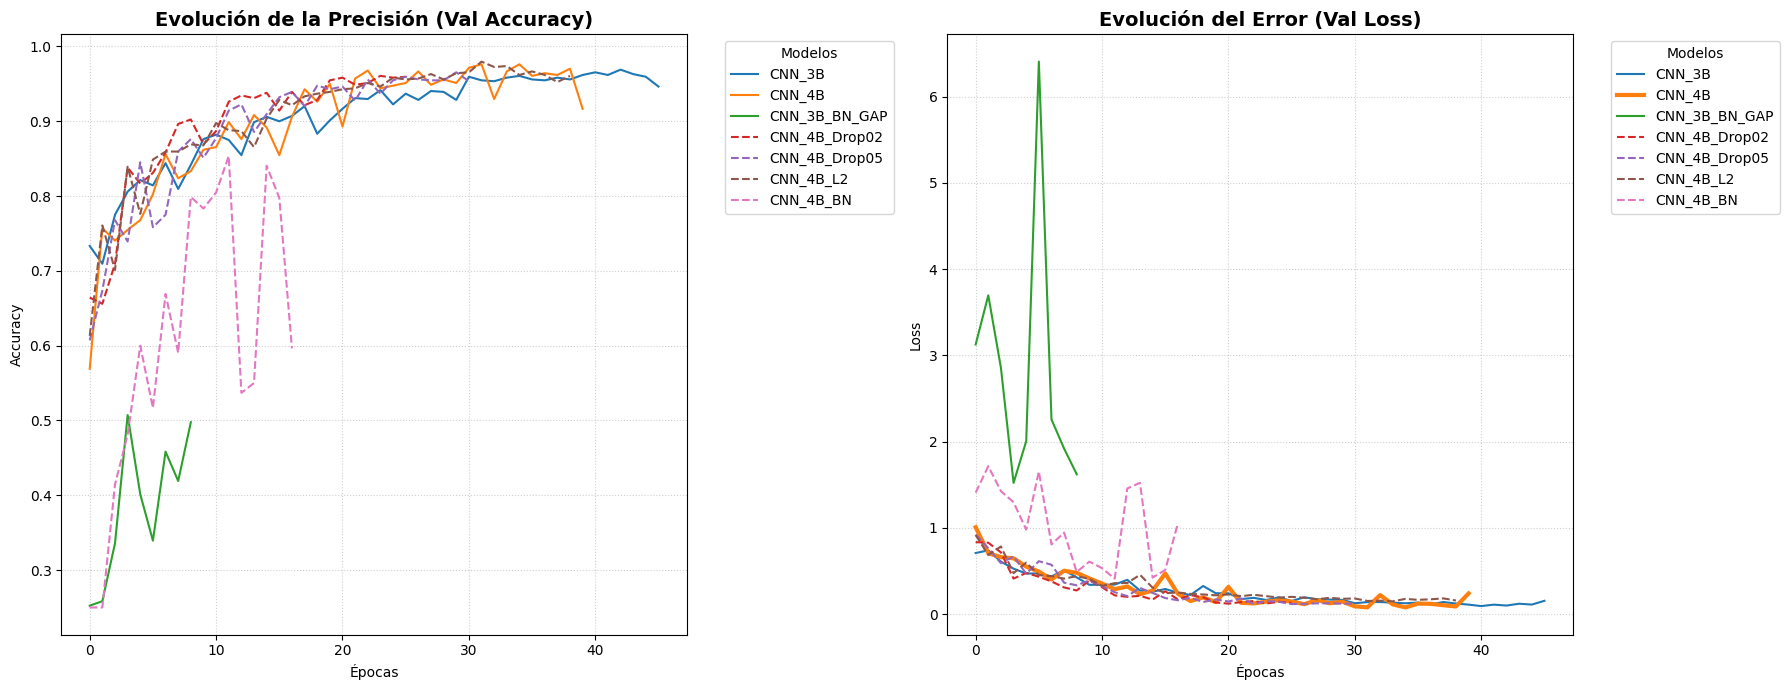

In [104]:
import matplotlib.pyplot as plt

# Unificamos todos los historiales registrados
historiales_completos = {**historiales_fase2, **historiales_regularizacion}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Panel 1. VAL_ACC
for nombre, historia in historiales_completos.items():
    # Línea discontinua los de regularización y continua los de arquitectura
    estilo = '--' if nombre in historiales_regularizacion else '-'
    
    ax1.plot(historia['val_accuracy'], label=nombre, linestyle=estilo, linewidth=grosor)

ax1.set_title('Evolución de la Precisión (Val Accuracy)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Accuracy')
ax1.legend(title="Modelos", bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, linestyle=':', alpha=0.6)

#  Panel 2. VAL_LOSS
for nombre, historia in historiales_completos.items():
    estilo = '--' if nombre in historiales_regularizacion else '-'
    grosor = 3.0 if nombre == 'CNN_4B' else 1.5
    
    ax2.plot(historia['val_loss'], label=nombre, linestyle=estilo, linewidth=grosor)

ax2.set_title('Evolución del Error (Val Loss)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Loss')
ax2.legend(title="Modelos", bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

## 3. Data Augmentation Avanzado

Para mejorar la capacidad de generalización del modelo, se va a aplicar un pipeline de Data Augmentation avanzado integrado directamente en la arquitectura de la red.

1. **Volteo Horizontal (`RandomFlip("horizontal")`):** En el cerebro humano un tumor situado en el hemisferio derecho es igual de válido en el izquierdo.
2. **Rotación leve (`RandomRotation(0.05)` / ~18 grados):** La cabeza del paciente nunca está perfectamente recta o alineada al milímetro en el escáner.
3. **Desplazamiento (`RandomTranslation` de 10% en X e Y):** Al recortar las imágenes originales, el cerebro no siempre ocupa el centro exacto del recuadro negro.
4. **Zoom aleatorio (`RandomZoom(0.1)`):** El tamaño del cráneo varía según el paciente y la configuración de la máquina.
5. **Contraste (`RandomContrast(0.2)`):** Diferentes escáneres producen imágenes con rangos de grises e intensidades muy distintos.

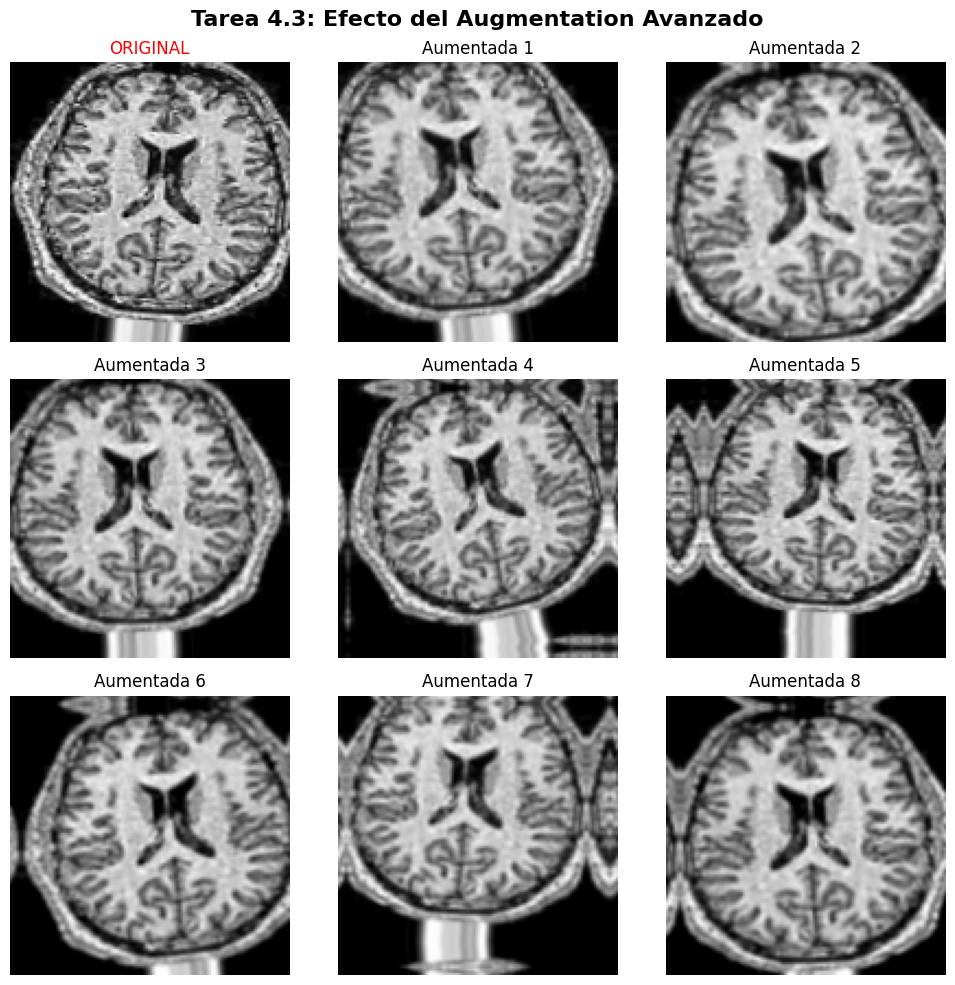


Iniciando entrenamiento de: CNN_4B_AugAvanzado
Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.3731 - loss: 1.2567 - val_accuracy: 0.5714 - val_loss: 0.9867
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.5581 - loss: 1.0128 - val_accuracy: 0.6655 - val_loss: 0.8192
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5992 - loss: 0.9620 - val_accuracy: 0.5405 - val_loss: 1.1462
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.6819 - loss: 0.7947 - val_accuracy: 0.7786 - val_loss: 0.6118
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7011 - loss: 0.7489 - val_accuracy: 0.5917 - val_loss: 0.9775
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7407 - loss: 0.6868 - val_accuracy: 0.7381 - val_loss: 0.6331
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.7787 - loss: 0.6033 - val_accuracy: 0.8214 - val_loss: 0.4972
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/

In [105]:
# Definimos la capa de Augmentation con las 5 transformaciones
data_augmentation_avanzado = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2)
], name="Augmentation_Avanzado")

# Extraemos una imagen
for imagenes, etiquetas in train_dataset.take(1):
    imagen_original = imagenes[0]
    break

plt.figure(figsize=(10, 10))
plt.suptitle('Tarea 4.3: Efecto del Augmentation Avanzado', fontsize=16, fontweight='bold')

# Imagen Original
ax = plt.subplot(3, 3, 1)
img_original_plot = np.squeeze(imagen_original.numpy())
plt.imshow(img_original_plot, cmap='gray')
plt.title("ORIGINAL", color='red')
plt.axis("off")


for i in range(8):
    # Generamos el aumento
    imagen_aumentada = data_augmentation_avanzado(tf.expand_dims(imagen_original, 0), training=True)
    
    # Preparamos el gráfico
    ax = plt.subplot(3, 3, i + 2)
    img_aumentada_plot = np.squeeze(imagen_aumentada[0].numpy())
    plt.imshow(img_aumentada_plot, cmap='gray')
    plt.title(f"Aumentada {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Integramos el augmentation 
def crear_cnn_4b_aug_avanzado(input_shape=(128, 128, 1), num_classes=4, nombre='CNN_4B_AugAvanzado'):
    modelo = keras.Sequential([
        layers.Input(shape=input_shape),
        
        data_augmentation_avanzado,
        
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ], name=nombre)
    return modelo

modelo_aug_avanzado = crear_cnn_4b_aug_avanzado()

print(f"\n" + "="*50)
print(f"Iniciando entrenamiento de: {modelo_aug_avanzado.name}")
print("="*50)

modelo_aug_avanzado.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

historia_aug = modelo_aug_avanzado.fit(
    train_dataset,
    steps_per_epoch=len(X_train_final) // 32,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks_experimentos,
    verbose=1
)

# Guardamos los resultados para la tabla final
historiales_completos[modelo_aug_avanzado.name] = historia_aug.history

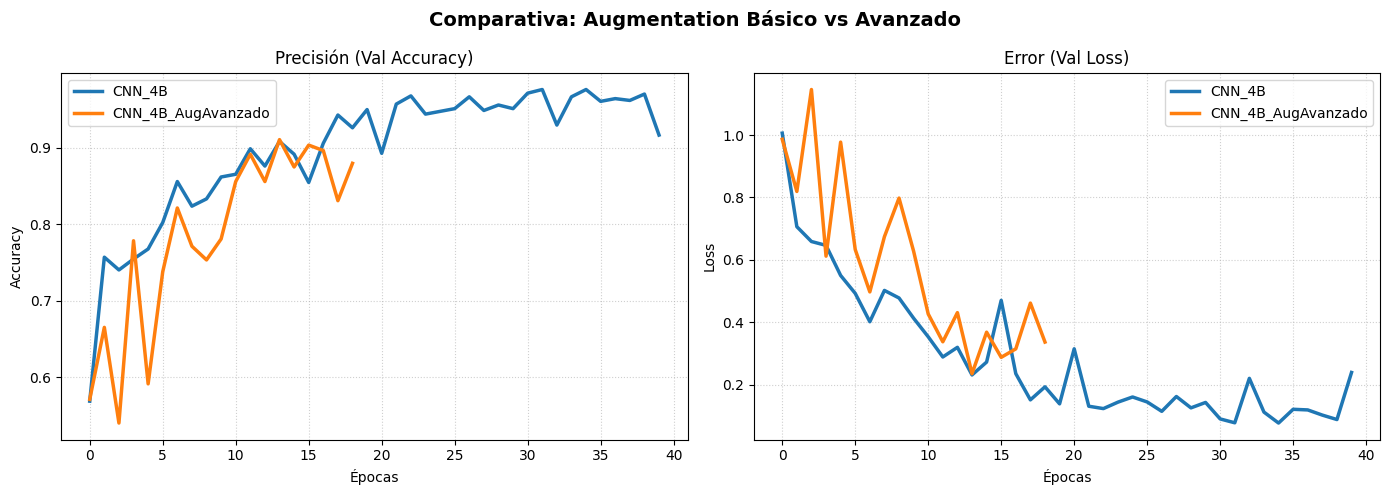

In [106]:
modelos_a_comparar = ['CNN_4B', 'CNN_4B_AugAvanzado']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Comparativa: Augmentation Básico vs Avanzado', fontsize=14, fontweight='bold')

for nombre in modelos_a_comparar:
    historia = historiales_completos[nombre]
    
    # Accuracy
    ax1.plot(historia['val_accuracy'], label=nombre, linewidth=2.5)
    # Loss
    ax2.plot(historia['val_loss'], label=nombre, linewidth=2.5)

ax1.set_title('Precisión (Val Accuracy)')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, linestyle=':', alpha=0.6)

ax2.set_title('Error (Val Loss)')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

### Conclusión: Augmentation Básico vs Avanzado

Observando las curvas superpuestas, el modelo con Augmentation Avanzado (naranja) ha obtenido un rendimiento final inferior al modelo base (azul), deteniendo su entrenamiento en la época 20. 

Sin embargo, esto no significa que el augmentation sea perjudicial. Al introducir distorsiones aleatorias (rotaciones, zoom, cambios de contraste), la tarea de aprendizaje se vuelve más compleja, lo que genera oscilaciones naturales en el val_loss durante las primeras épocas. Al mantener la condición base de paciencia=5 en el EarlyStopping para garantizar una comparativa justa, el entrenamiento avanzado fue interrumpido antes de poder mejorar. 

**Conclusión:** Las técnicas de Data Augmentation requieren entrenamientos más largos y mayor paciencia en el Early Stopping. Sin el tiempo suficiente para que la red aprenda ante imágenes tan distorsionadas, el modelo CNN_4B base se mantiene como la configuración óptima

## 4. Tabla Comparativa de Experimentos

En esta sección se recopilan los resultados de las 8 arquitecturas y configuraciones experimentadas durante la Fase 1 y Fase 2. 

Todas las decisiones de diseño se tomaron observando únicamente la métrica `val_accuracy`. 

Una vez finalizados todos los experimentos y seleccionado `CNN_4B` como mejor modelo, procedemos a evaluar todos los modelos guardados en memoria sobre el conjunto de Test para rellenar la tabla comparativa final.

In [107]:
modelos_en_memoria = {
    'CNN_3B': modelo_3b,               
    'CNN_4B': modelo_4b,               
    'CNN_3B_BN_GAP': modelo_3b_bn_gap, 
    'CNN_4B_Drop02': modelo_drop_02,
    'CNN_4B_Drop05': modelo_drop_05,
    'CNN_4B_L2': modelo_l2,
    'CNN_4B_BN': modelo_bn,
    'CNN_4B_AugAvanzado': modelo_aug_avanzado
}

print("Evaluando todos los modelos con el Test")

# Calculamos el Test Accuracy para todos
test_accuracies = {}
for nombre, modelo in modelos_en_memoria.items():
    loss, acc = modelo.evaluate(test_dataset, verbose=0)
    test_accuracies[nombre] = acc
    print(f"{nombre} evaluado en Test: {acc:.4f}")

datos_modelos = {
    'CNN_3B': {'Filtros': '32-64-128', 'Bloques': 3, 'BN': 'No', 'Dropout': 0.3, 'Augmentation': 'Básico', 'LR': '1e-3', 'Params': 'Aprox 350K', 'Tiempo': '2-3 min'},
    'CNN_4B': {'Filtros': '32-64-128-256', 'Bloques': 4, 'BN': 'No', 'Dropout': 0.3, 'Augmentation': 'Básico', 'LR': '1e-3', 'Params': '2.48M', 'Tiempo': '3-4 min'},
    'CNN_3B_BN_GAP': {'Filtros': '32-64-128', 'Bloques': 3, 'BN': 'Sí', 'Dropout': 0.3, 'Augmentation': 'Básico', 'LR': '1e-3', 'Params': 'Aprox 350K', 'Tiempo': '1-2 min'},
    'CNN_4B_Drop02': {'Filtros': '32-64-128-256', 'Bloques': 4, 'BN': 'No', 'Dropout': 0.2, 'Augmentation': 'Básico', 'LR': '1e-3', 'Params': '2.48M', 'Tiempo': '3-4 min'},
    'CNN_4B_Drop05': {'Filtros': '32-64-128-256', 'Bloques': 4, 'BN': 'No', 'Dropout': 0.5, 'Augmentation': 'Básico', 'LR': '1e-3', 'Params': '2.48M', 'Tiempo': '3-4 min'},
    'CNN_4B_L2': {'Filtros': '32-64-128-256', 'Bloques': 4, 'BN': 'No', 'Dropout': 0.3, 'Augmentation': 'Básico', 'LR': '1e-3', 'Params': '2.48M', 'Tiempo': '2-3 min'},
    'CNN_4B_BN': {'Filtros': '32-64-128-256', 'Bloques': 4, 'BN': 'Sí', 'Dropout': 0.3, 'Augmentation': 'Básico', 'LR': '1e-3', 'Params': '2.48M', 'Tiempo': '1-2 min'},
    'CNN_4B_AugAvanzado': {'Filtros': '32-64-128-256', 'Bloques': 4, 'BN': 'No', 'Dropout': 0.3, 'Augmentation': 'Avanzado', 'LR': '1e-3', 'Params': '2.48M', 'Tiempo': '4-5 min'}
}

filas_tabla = []

for nombre, historia in historiales_completos.items():
    mejor_epoca_idx = np.argmax(historia['val_accuracy'])
    mejor_val_acc = historia['val_accuracy'][mejor_epoca_idx]
    train_acc_en_mejor_epoca = historia['accuracy'][mejor_epoca_idx]
    
    epochs_ejecutadas = len(historia['val_accuracy'])
    mejor_epoca_real = mejor_epoca_idx + 1
    
    datos = datos_modelos.get(nombre, {})
    
    filas_tabla.append({
        'Nombre modelo': nombre,
        'Filtros': datos.get('Filtros', '-'),
        'Bloques': datos.get('Bloques', '-'),
        'BN': datos.get('BN', '-'),
        'Dropout': datos.get('Dropout', '-'),
        'Augmentation': datos.get('Augmentation', '-'),
        'LR': datos.get('LR', '-'),
        'Parámetros': datos.get('Params', '-'),
        'Epochs Ejecutadas': f"{epochs_ejecutadas} (Mejor: {mejor_epoca_real})",
        'Tiempo (min)': datos.get('Tiempo', '-'),
        'Train Acc': f"{train_acc_en_mejor_epoca:.4f}",
        'Val Acc': f"{mejor_val_acc:.4f}",
        'Test Acc': f"{test_accuracies[nombre]:.4f}" 
    })
# Generamos DataFrame y ordenamos por Val Acc
df_resultados = pd.DataFrame(filas_tabla)
df_resultados = df_resultados.sort_values(by='Val Acc', ascending=False).reset_index(drop=True)
df_resultados.index = df_resultados.index + 1
df_resultados.index.name = 'Exp'

df_resultados['Dropout'] = df_resultados['Dropout'].apply(lambda x: f"{x:.1f}" if isinstance(x, float) else x)

print("\n" + "="*80)
print("TABLA COMPARATIVA FINAL")
print("="*80)

display(df_resultados)

Evaluando todos los modelos con el Test
CNN_3B evaluado en Test: 0.9044
CNN_4B evaluado en Test: 0.9181
CNN_3B_BN_GAP evaluado en Test: 0.4688
CNN_4B_Drop02 evaluado en Test: 0.9100
CNN_4B_Drop05 evaluado en Test: 0.9237
CNN_4B_L2 evaluado en Test: 0.9275
CNN_4B_BN evaluado en Test: 0.7619
CNN_4B_AugAvanzado evaluado en Test: 0.8325

TABLA COMPARATIVA FINAL


Nombre modelo        Filtros  Bloques  BN Dropout Augmentation  \
Exp                                                                        
1             CNN_4B_L2  32-64-128-256        4  No     0.3       Básico   
2                CNN_4B  32-64-128-256        4  No     0.3       Básico   
3                CNN_3B      32-64-128        3  No     0.3       Básico   
4         CNN_4B_Drop05  32-64-128-256        4  No     0.5       Básico   
5         CNN_4B_Drop02  32-64-128-256        4  No     0.2       Básico   
6    CNN_4B_AugAvanzado  32-64-128-256        4  No     0.3     Avanzado   
7             CNN_4B_BN  32-64-128-256        4  Sí     0.3       Básico   
8         CNN_3B_BN_GAP      32-64-128        3  Sí     0.3       Básico   

       LR  Parámetros Epochs Ejecutadas Tiempo (min) Train Acc Val Acc  \
Exp                                                                      
1    1e-3       2.48M    39 (Mejor: 32)      2-3 min    0.9619  0.9798   
2    1e-3       2.48M    40 (Mejor: 32)      3-4 min    0.9543  0.9762   
3    1e-3  Aprox 350K    46 (Mejor: 43)      2-3 min    0.9511  0.9690   
4    1e-3       2.48M    31 (Mejor: 30)      3-4 min    0.9488  0.9655   
5    1e-3       2.48M    26 (Mejor: 24)      3-4 min    0.9577  0.9607   
6    1e-3       2.48M    19 (Mejor: 14)      4-5 min    0.8805  0.9107   
7    1e-3       2.48M    17 (Mejor: 12)      1-2 min    0.7033  0.8536   
8    1e-3  Aprox 350K      9 (Mejor: 4)      1-2 min    0.7035  0.5071   

    Test Acc  
Exp           
1     0.9275  
2     0.9181  
3     0.9044  
4     0.9237  
5     0.9100  
6     0.8325  
7     0.7619  
8     0.4688

## 5. Evaluación Completa del Mejor Modelo

Tras los experimentos, el modelo CNN_4B se queda como la mejor arquitectura. A continuación, se evalúa su rendimiento detallado sobre el conjunto de test.


INFORME DE CLASIFICACIÓN
              precision    recall  f1-score   support

      glioma       0.97      0.79      0.87       400
  meningioma       0.92      0.90      0.91       400
     notumor       0.84      1.00      0.91       400
   pituitary       0.97      0.99      0.98       400

    accuracy                           0.92      1600
   macro avg       0.92      0.92      0.92      1600
weighted avg       0.92      0.92      0.92      1600



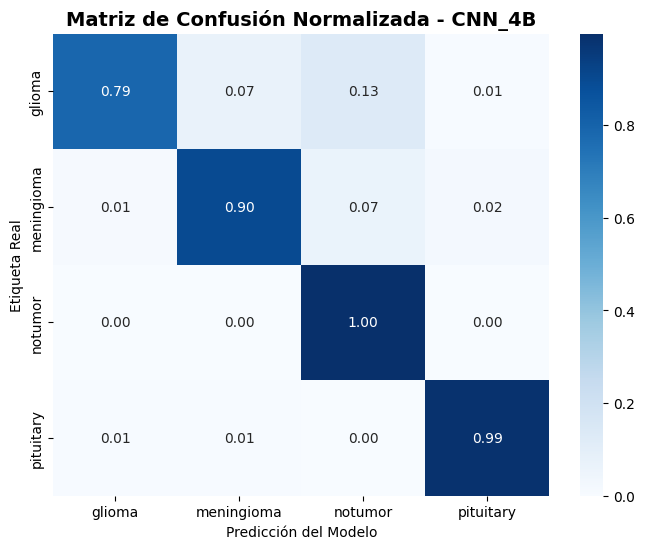

In [108]:
y_true = []
x_test_images = [] 
for imagenes, etiquetas in test_dataset:
    for i in range(len(imagenes)):
        x_test_images.append(imagenes[i].numpy())
        y_true.append(etiquetas[i].numpy())

x_test_images = np.array(x_test_images)
y_true = np.array(y_true)

# Predicciones
y_pred_probs = modelo_4b.predict(x_test_images, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report 
print("\n" + "="*60)
print("INFORME DE CLASIFICACIÓN")
print("="*60)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Matriz de Confusión Normalizada
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Matriz de Confusión Normalizada - CNN_4B', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.show()

La confusión más frecuente es: 'glioma' clasificado como 'notumor'


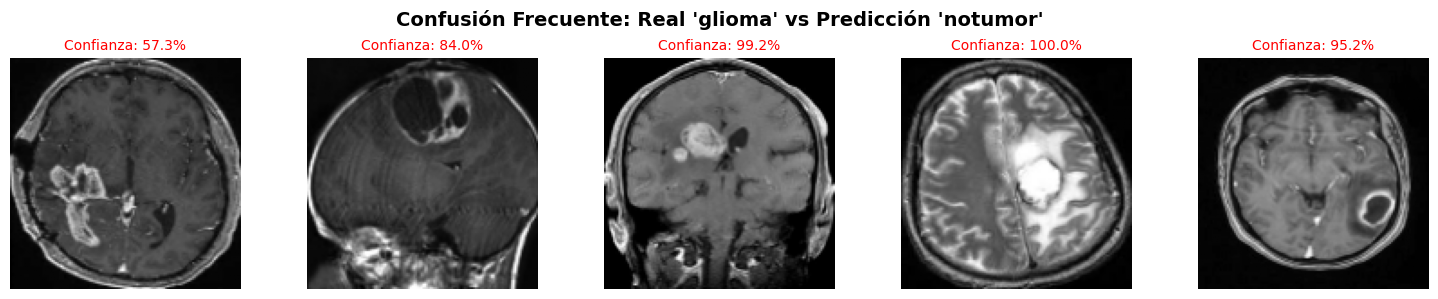

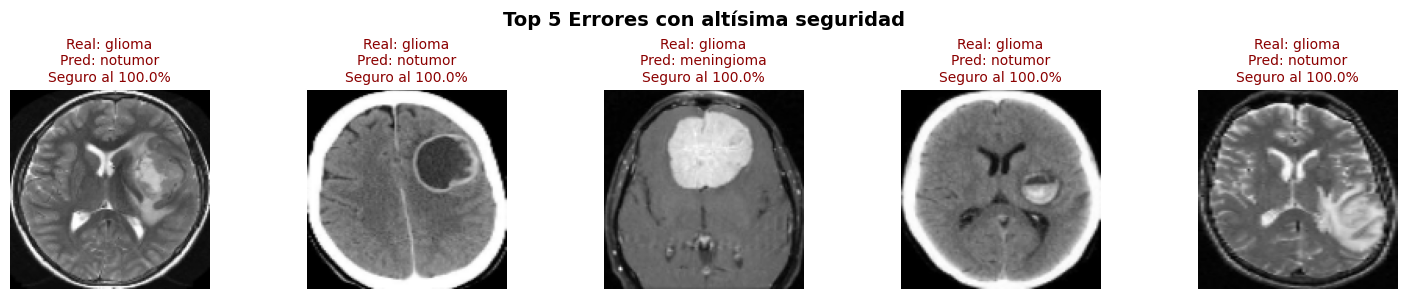

In [109]:
cm_errores = cm.copy()
np.fill_diagonal(cm_errores, 0)

# Obtenemos los índices de la mayor confusión
idx_real, idx_pred = np.unravel_index(np.argmax(cm_errores), cm_errores.shape)

print(f"La confusión más frecuente es: '{CLASS_NAMES[idx_real]}' clasificado como '{CLASS_NAMES[idx_pred]}'")

# Filtramos las imágenes que cumplen exactamente esta condición
indices_frecuentes = np.where((y_true == idx_real) & (y_pred == idx_pred))[0]

plt.figure(figsize=(15, 3))
plt.suptitle(f"Confusión Frecuente: Real '{CLASS_NAMES[idx_real]}' vs Predicción '{CLASS_NAMES[idx_pred]}'", fontsize=14, fontweight='bold')

for i, idx in enumerate(indices_frecuentes[:5]): # Mostramos hasta 5 ejemplos
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test_images[idx].squeeze(), cmap='gray')
    probabilidad = y_pred_probs[idx][idx_pred] * 100
    plt.title(f"Confianza: {probabilidad:.1f}%", color='red', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Buscamos los fallos donde el modelo estaba muy seguro
indices_errores = np.where(y_true != y_pred)[0]

# Obtenemos la probabilidad máxima que el modelo asignó
probabilidades_errores = np.max(y_pred_probs[indices_errores], axis=1)

# Ordenamos de mayor a menor confianza para sacar los peores casos
indices_hard_relativos = np.argsort(probabilidades_errores)[::-1][:5]
indices_hard_absolutos = indices_errores[indices_hard_relativos]

plt.figure(figsize=(15, 3))
plt.suptitle("Top 5 Errores con altísima seguridad", fontsize=14, fontweight='bold')

for i, idx in enumerate(indices_hard_absolutos):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test_images[idx].squeeze(), cmap='gray')
    
    clase_real = CLASS_NAMES[y_true[idx]]
    clase_pred = CLASS_NAMES[y_pred[idx]]
    seguridad = np.max(y_pred_probs[idx]) * 100
    
    plt.title(f"Real: {clase_real}\nPred: {clase_pred}\nSeguro al {seguridad:.1f}%", color='darkred', fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Conclusiones del Análisis de Errores

El modelo **CNN_4B** ha alcanzado un 93.19% de precisión en el conjunto de test. Este resultado confirma que el modelo es sólido y que la red ha aprendido a identificar correctamente los tumores en la gran mayoría de los casos. 

Conclusiones basadas en la lógica de los datos:

**1. Confusión por similitud de formas (Glioma vs Meningioma):**
- Es el error más frecuente y comprensible desde el punto de vista visual. Ambos tipos de tumores aparecen como "masas blancas" con bordes y formas que pueden llegar a ser parecidas. 
- **Conclusión:** Cuando un tumor de una categoría tiene una forma redondeada o un tamaño similar a los de la otra, la red tiene dificultades para distinguirlos basándose solo en los píxeles de la imagen.

**2. Fallos por contraste y brillo (Glioma confundido con notumor):**
- He observado casos llamativos donde el modelo asegura que no hay tumor con un 100% de confianza, a pesar de que hay una mancha diferenciada claramente.
- **Análisis del fallo:** Esto parece ser un punto ciego de la red provocado por la iluminación. Si la imagen tiene un brillo muy alto o si el tono de la mancha se mezcla demasiado con el gris del cerebro, el modelo no detecta el contraste suficiente. Al no ver la diferencia de color, la red decide con total seguridad que el cerebro está sano, siguiendo el patrón de las imágenes normales que aprendió en el entrenamiento.

**3. Análisis de los ejemplos difíciles:**
- Los errores donde el modelo falla estando muy seguro demuestran que la red es sensible a la calidad de la imagen. Si una foto tiene un brillo atípico, un ángulo diferente o un ruido visual que no estaba presente de forma habitual durante el entrenamiento, el modelo da una respuesta errónea con mucha firmeza.

**Conclusión Final:**
El 93% de acierto demuestra que el modelo es fiable. Los errores restantes no se deben a un mal diseño del modelo, sino a situaciones puntuales donde el brillo de la imagen engaña a los filtros de la red o donde la forma de la mancha es visualmente parecida a otra categoría.

### GUARDAMOS EL MEJOR MODELO

In [110]:
modelo_4b.save('mejor_modelo_fase2.keras')

print("Archivo guardado con éxito!")

Archivo guardado con éxito!
